**Import libraries**

In [1]:
import config as config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as seabornInstance 
from datetime import date, timedelta, datetime
from operator import itemgetter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import plotly.graph_objects as go
from pandas_datareader import data as pdr

#yahoo finance and pandadata reader override
import yfinance as yf
yf.pdr_override()

#machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Try out Vader Sentiment Analyzer**

In [2]:
#call analyser object
analyser = SentimentIntensityAnalyzer()

In [3]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [4]:
sentiment_analyzer_scores("Today is an okay day.")

{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.2263}

In [5]:
sentiment_analyzer_scores("Today is an amazing day!")

{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.6239}

In [6]:
sentiment_analyzer_scores("Today is an amazing day! Vader is working but it took a while")

{'neg': 0.0, 'neu': 0.817, 'pos': 0.183, 'compound': 0.4003}

In [7]:
sentiment_analyzer_scores("Today kind of sucked.")

{'neg': 0.523, 'neu': 0.477, 'pos': 0.0, 'compound': -0.5095}

**Pull in Live News Data from News API**
<p>News API only display news up to a month old</p>

In [165]:
#enter company and api key
company = input('company: ')
stock_ticker = input('stock ticker: ')
api_key = config.api_key;

company: google
stock ticker: GOOGL


<h4 style='background:#ffbdb3'>Major limitation of News API: Free version has max of 100 results per call; 1 month old max; 500 request per day</h4>
<h4>To get around this, we will make a request for each day, and compile the first 100 most popular results for each day</h4>

In [166]:
#get dates, 28 days from today (28 days max as per free api)
today = date.today() - timedelta(0)
numdays = 28
date_list = [today - timedelta(days=x) for x in range(numdays)]

In [167]:
#try return news for 1 day, make 7 requests, sort by most popular results
total_res = []

for x in range(0, numdays):  
    url = ('http://newsapi.org/v2/everything?'
           'q=' + company + '&'
           'from=' + str(date_list[x]) + '&'
           'to=' + str(date_list[x]) + '&'
           'language=en&'
           'sortBy=popularity&'
           'pageSize=100&'
           'apiKey=' + api_key)
    response = requests.get(url)
    total_res.append(response.json())


#print('Total Results: ' + str(response.json().get('totalResults')))

#print(*total_res, sep = '\n')   

In [168]:
#put all 'articles' in 1 list, then remove the nested list
articles = []
for x in range(0, len(total_res)):
    articles.append(total_res[x]['articles'])

news = []
def removeNesting(nestedList):
    for i in nestedList:
        if type(i) == list:
            removeNesting(i)
        else: 
            news.append(i)
            
removeNesting(articles)
#print(news)

**Perform Analysis on the News Title**

In [169]:
#news = response.json().get('articles')

#add title score:
na_score = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

for item in news:
    if item['title'] is None:
        item.update({'title_score': na_score})
    else:
        item.update({'title_score': sentiment_analyzer_scores(item['title'])})
    if item['description'] is None:
        item.update({'desc_score': na_score})
    else:
        item.update({'desc_score': sentiment_analyzer_scores(item['description'])})

In [170]:
news_df = pd.DataFrame(news)
news_df.sort_values(by=['publishedAt'])

print('row and column: ' + str(news_df.shape))
#news_df.head()

row and column: (2800, 10)


**Plot Title Sentiment Score**

In [171]:
def graph_sentiment(text, score, graph_title):
    x = text
    y = [d.get('neg') for d in score]
    y1 = [d.get('neu') for d in score]
    y2 = [d.get('pos') for d in score]
    y3 = [d.get('compound') for d in score]

    fig = go.Figure(go.Bar(x=x, y=y, name='Negative', marker_color='#EE7674'))
    fig.add_trace(go.Bar(x=x, y=y1, name='Neutral', marker_color='#247BA0'))
    fig.add_trace(go.Bar(x=x, y=y2, name='Positive'))
    fig.add_trace(go.Bar(x=x, y=y3, name='Compound'))

    fig.update_layout(title=graph_title)
    fig.show()


#graph_sentiment(news_df['title'], news_df['title_score'], 'Title Sentiment')

In [172]:
#graph_sentiment(news_df['description'], news_df['desc_score'], 'Description Sentiment')

***How to interpret Compound Values?*** 
<p>The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.</p>

**Next Step: Populate the score on a daily basis**
<p> Use the mean of the headline score for each day </p>

In [173]:
#extract date and scores
news_score_df = news_df[['publishedAt', 'title_score', 'desc_score']].copy()

#remove time from datetime
news_score_df['publishedAt'] = pd.to_datetime(news_score_df['publishedAt'].str.split('T').str[0])

#convert object into datetime
#pd.to_datetime(news_score_df['publishedAt'])

#populate each score in nested title_score and desc_score into own column
news_score_df = pd.concat([news_score_df, 
                 pd.DataFrame((d for i, d in news_score_df['title_score'].iteritems()))], 
                 axis=1)

news_score_df = pd.concat([news_score_df, 
                 pd.DataFrame((d for i, d in news_score_df['desc_score'].iteritems()))], 
                 axis=1)


news_score_df.columns = ['publishedAt', 'title_score', 'desc_score', 
                         't_neg', 't_neu', 't_pos', 't_compound',
                         'd_neg', 'd_neu', 'd_pos', 'd_compound']

daily_score_df = news_score_df.groupby('publishedAt', as_index=True)[['t_neg', 't_neu', 't_pos', 't_compound',
                         'd_neg', 'd_neu', 'd_pos', 'd_compound']].mean().reset_index()

#add % change to each column
#daily_score_df['t_neg_pc'] = daily_score_df['t_neg'].pct_change()

daily_score_df.head()

,publishedAt,t_neg,t_neu,t_pos,t_compound,d_neg,d_neu,d_pos,d_compound
0,2020-03-06,0.070720,0.845730,0.083550,0.028800,0.065170,0.845840,0.088950,0.105749
1,2020-03-07,0.056480,0.855500,0.088050,0.047144,0.055010,0.860110,0.084840,0.155325
2,2020-03-08,0.061816,0.845367,0.092816,0.049369,0.058316,0.840378,0.091112,0.162136
3,2020-03-09,0.070490,0.842814,0.086716,0.019286,0.075451,0.837755,0.086765,0.022965
4,2020-03-10,0.062320,0.852320,0.085360,0.035751,0.058100,0.877310,0.064580,0.043184


In [174]:
def daily_score_graph(graph_title, x, y1, y2, y3, y4):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y1,
                        mode='lines+markers',
                        name='neg',
                        line=dict(color='#EE7674')))
    fig.add_trace(go.Scatter(x=x, y=y2,
                        mode='lines+markers',
                        name='neu',
                        line=dict(color='#247BA0')))
    fig.add_trace(go.Scatter(x=x, y=y3,
                        mode='lines+markers', 
                        name='pos'))
    fig.add_trace(go.Scatter(x=x, y=y4,
                        mode='lines+markers', 
                        name='compound',
                        line=dict(width=4)))

    fig.update_layout(title=graph_title)
    fig.show()

daily_score_graph('Daily Title Score', daily_score_df['publishedAt'], 
                  daily_score_df['t_neg'], daily_score_df['t_neu'], daily_score_df['t_pos'], daily_score_df['t_compound'])

In [175]:
daily_score_graph('Daily Description Score', daily_score_df['publishedAt'], 
                  daily_score_df['d_neg'], daily_score_df['d_neu'], daily_score_df['d_pos'], daily_score_df['d_compound'])


**Next Step: Pull Daily price of S&P and Dow Jones**

reference: https://pypi.org/project/yfinance/

In [176]:
stock_data = pdr.get_data_yahoo(stock_ticker, start=date_list[-1], end=date_list[0])
stock_data_df = pd.DataFrame(stock_data).reset_index()

stock_data_df['Adj Close PC'] = stock_data_df['Adj Close'].pct_change()

print('Start Date: ' + str(date_list[-1]))
print('End Date: ' + str(date_list[0]))
stock_data_df.head(15)

[*********************100%***********************]  1 of 1 completed
Start Date: 2020-03-06
End Date: 2020-04-02


,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close PC
0,2020-03-06,1269.949951,1302.750000,1257.209961,1295.739990,1295.739990,3232000,NaN
1,2020-03-09,1204.959961,1252.729980,1198.040039,1215.790039,1215.790039,3462600,-0.061702
2,2020-03-10,1254.390015,1275.849976,1214.510010,1275.170044,1275.170044,2743600,0.048841
3,2020-03-11,1248.270020,1256.930054,1191.140015,1210.900024,1210.900024,2736600,-0.050401
4,2020-03-12,1122.619995,1188.750000,1108.469971,1111.550049,1111.550049,4716300,-0.082046
5,2020-03-13,1174.989990,1214.400024,1112.290039,1214.270020,1214.270020,3970000,0.092411
6,2020-03-16,1089.609985,1145.469971,1067.079956,1073.000000,1073.000000,4826000,-0.116342
7,2020-03-17,1090.640015,1126.000000,1049.099976,1118.060059,1118.060059,4159700,0.041994
8,2020-03-18,1059.939941,1104.989990,1037.000000,1091.189941,1091.189941,4652200,-0.024033
9,2020-03-19,1088.219971,1152.609985,1055.550049,1111.670044,1111.670044,3703200,0.018769


In [177]:
#plot daily close for last 7 days
def stock_graph():
    x = stock_data_df['Date']
    y = stock_data_df['Adj Close']

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y,
                        mode='lines+markers',
                        name='Daily Close',
                        line=dict(color='#EE7674')))

    graph_title = str(company).upper() + ' Daily Close'
    fig.update_layout(title=graph_title)
    fig.show()

stock_graph()

#add label for day of week
#remove weekends

**Compare % change each day between score and price**

In [178]:
price_score_df = pd.merge(daily_score_df, stock_data_df, how='left', left_on='publishedAt', right_on='Date')

#saving data to csv
#price_score_df.to_csv(r'/Users/susanqu/Desktop/Data Science/SentimentAnalysis/cmg.csv', index=False)

#check if any columns has NaN
price_score_df.isnull().any()

publishedAt     False
t_neg           False
t_neu           False
t_pos           False
t_compound      False
d_neg           False
d_neu           False
d_pos           False
d_compound      False
Date             True
Open             True
High             True
Low              True
Close            True
Adj Close        True
Volume           True
Adj Close PC     True
dtype: bool

In [179]:
price_score_df.describe()

,t_neg,t_neu,t_pos,t_compound,d_neg,d_neu,d_pos,d_compound,Open,High,Low,Close,Adj Close,Volume,Adj Close PC
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,18.000000
mean,0.059157,0.858525,0.081962,0.041224,0.055222,0.862246,0.081448,0.111524,1140.367355,1172.722110,1108.185791,1144.992117,1144.992117,3.706968e+06,-0.007386
std,0.007430,0.013997,0.014949,0.039780,0.008587,0.014710,0.013186,0.075135,62.936862,61.639919,64.979178,68.626301,68.626301,7.084218e+05,0.057295
min,0.043460,0.822951,0.052889,-0.048515,0.037614,0.822728,0.059697,-0.008704,1056.369995,1066.910034,1008.869995,1054.130005,1054.130005,2.597100e+06,-0.116342
25%,0.055623,0.845639,0.073684,0.019997,0.049492,0.856054,0.074325,0.061093,1097.309998,1135.904968,1064.589966,1101.859985,1101.859985,3.185850e+06,-0.049122
50%,0.058880,0.861858,0.079758,0.041944,0.056165,0.862975,0.078770,0.099347,1124.579956,1151.050049,1093.489990,1118.060059,1118.060059,3.703200e+06,-0.018607
75%,0.062648,0.868700,0.087049,0.050232,0.060460,0.873548,0.089063,0.157028,1161.859985,1201.575012,1124.505005,1186.910034,1186.910034,4.171650e+06,0.039613
max,0.076190,0.879850,0.119563,0.147971,0.075451,0.885800,0.122961,0.284922,1269.949951,1302.750000,1257.209961,1295.739990,1295.739990,4.826000e+06,0.092411


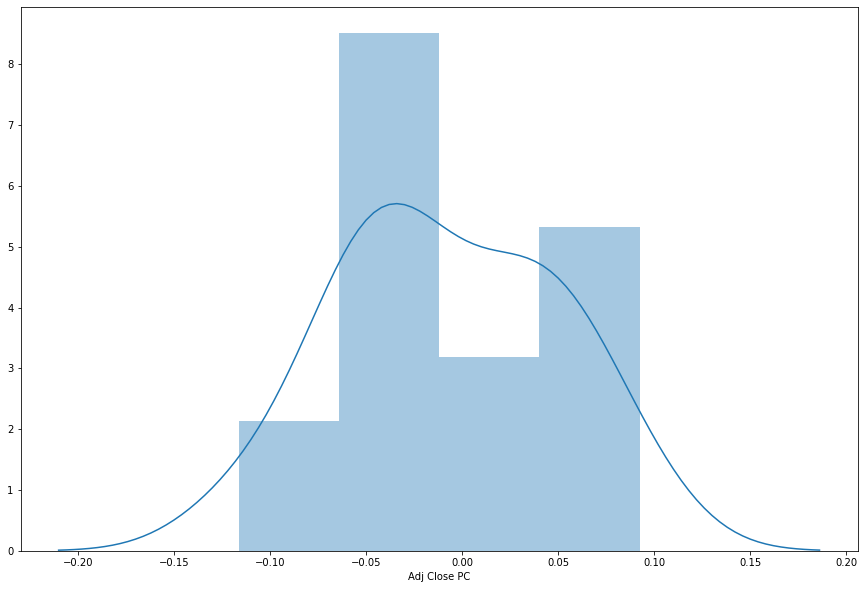

In [180]:
#check average of daily closing
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(price_score_df['Adj Close PC'])

**Predict Today's Closing Price based on Today's news score**

In [181]:
price_score_df.shape


(28, 17)

In [182]:
#adding weekday to df
price_score_df['day_of_week'] = price_score_df['publishedAt'].dt.day_name()

#remove weekend values and NaN values
ps_weekday_only_df = pd.DataFrame(price_score_df.dropna())

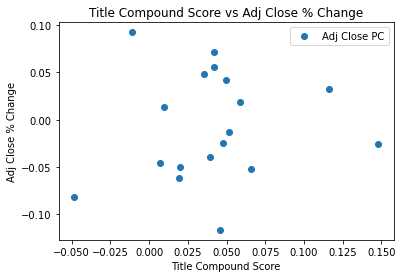

In [183]:
#plot scatter plot using Title Compound Score and Adj Close % Change
ps_weekday_only_df.plot(x='t_compound', y='Adj Close PC', style='o')
plt.title('Title Compound Score vs Adj Close % Change')
plt.xlabel('Title Compound Score')
plt.ylabel('Adj Close % Change')
plt.show()

y-intercept: [-0.02063208]
coef: [[0.1093657]]


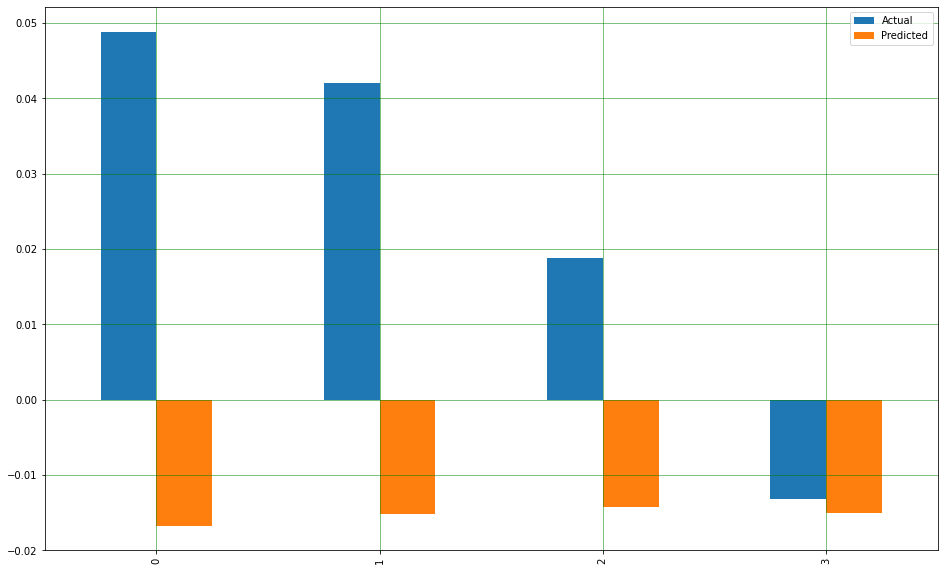

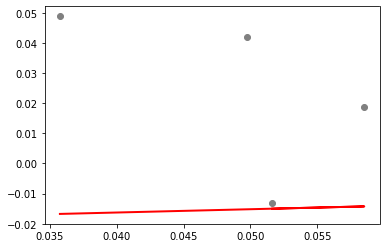

Root Mean Squared Error: 0.0465317590522553
SD in actual y test set:  0.024241499101307996
RMSE over SD of Actual y test:  1.9195083133181559


In [205]:
def single_regression():
    #define independant and dependant variables
    X = ps_weekday_only_df['t_compound'].values.reshape(-1, 1)
    y = ps_weekday_only_df['Adj Close PC'].values.reshape(-1, 1)

    #split, test, train - 80% for training, 20% for test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #train the data
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X_train, y_train)

    #to retrieve the y-intercept
    print('y-intercept: ' + str(regressor.intercept_))

    #to retrive the slope
    print('coef: ' + str(regressor.coef_))

    #predict y, Adj Close
    y_pred = regressor.predict(X_test)

    #compare the Real output in X_test with predicted value
    pred_rs1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    #visualize the comparison
    pred_rs1.plot(kind='bar', figsize=(16, 10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')

    plt.show()

    #plot regression line, predicted regression line against test value
    plt.scatter(X_test, y_test, color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()

    #valuation metrics
    rmse_y_pred = metrics.mean_squared_error(y_test, y_pred, squared=False)
    print('Root Mean Squared Error:', rmse_y_pred)

    #compare RMSE with Standard Deviation of the actual y in test dataset
    print('SD in actual y test set: ', y_test.std())

    print('RMSE over SD of Actual y test: ', rmse_y_pred/y_test.std())

single_regression()

**Conclusion:**
<p>The dataset is too small to perform a fair valuation. Depending on the stock entered, different coefficient is returned, some stocks have stronger correlation between Title Compound News Score than others. However the value of RMSE is much greater than the Standard Deviation of the Actual y test. The model with present amount of data is not sufficient to make predictions.</p>

**Using Multiple Linear Regression**

coef: [[0.29060569 0.33871477 5.78194954 4.77215114 3.19188947]]


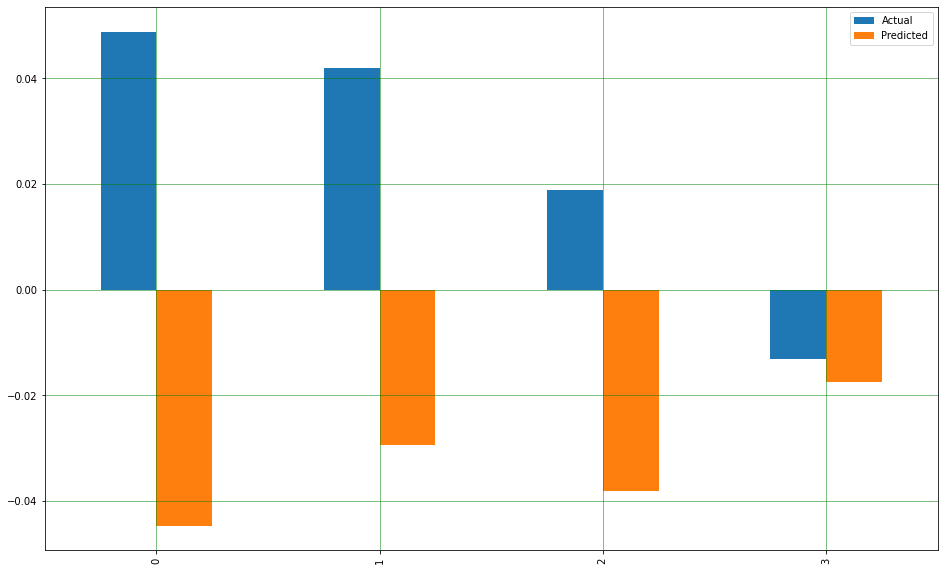

Root Mean Squared Error: 0.06535796872805817
SD in actual y test set:  0.024241499101307996
RMSE over SD of Actual y test:  2.6961190995210216


In [203]:
def multi_regression():
    #define independant and dependant variables
    X = ps_weekday_only_df[['t_compound', 'd_compound', 't_neg', 't_neu', 't_pos']]
    y = ps_weekday_only_df['Adj Close PC'].values.reshape(-1, 1)

    #split, test, train - 80% for training, 20% for test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #train the data
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X_train, y_train)

    #to retrive the slope
    print('coef: ' + str(regressor.coef_))

    #predict y, Adj Close
    y_pred = regressor.predict(X_test)


    #compare the Real output in X_test with predicted value
    pred_rs1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    #visualize the comparison
    pred_rs1.plot(kind='bar', figsize=(16, 10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')

    plt.show()
    
    #valuation metrics
    rmse_y_pred = metrics.mean_squared_error(y_test, y_pred, squared=False)
    print('Root Mean Squared Error:', rmse_y_pred)

    #compare RMSE with Standard Deviation of the actual y in test dataset
    print('SD in actual y test set: ', y_test.std())

    print('RMSE over SD of Actual y test: ', rmse_y_pred/y_test.std())

multi_regression()

**Conclusion:**
<p>The dataset is too small to perform a fair valuation. With 4 predicted values, the result is pretty much random. Need more data points to have meaningful result.</p>